In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from scipy.stats import norm
import time as ttt
import iisignature as iisig
from tqdm import *

# Create Paths from Brownian Motion Paths.

In [2]:
# W_full = np.load("W_10000.npy")
# print("Full BM Paths data with {} paths, and {} time steps.".format(W_full.shape[0], W_full.shape[1]))

## Modify the "steps" to select BM with new number of steps < 10000.

In [3]:
steps = 5000
n_paths = 100000

In [4]:
x0 = 1.0 # initial condition
sigma = 1 # volatility
mu = 0.02
r = 0.01 # risk free rate
Strike= 0.4 # strike price

batch_size = 100 # batch size
T = 1 # maturity
dt = T/steps # mesh size

In [5]:
def generate_t(T, batch_size = batch_size):
    '''
    generate time steps
    dim = batch_size * (steps+1). eg. 2000 * 101
    '''
    return np.tile(np.linspace(1e-8, T+1e-8, steps + 1, dtype = np.float32), (batch_size,1))

In [6]:
t = generate_t(T, steps)[0][0:]
len(t)

5001

In [7]:
# Selection BM with desired number of time steps.
# selection = np.linspace(0,W_full.shape[1]-1, steps+1, dtype = np.int)
# W_steps = W_full[:,selection]
# np.save("W_{}.npy".format(steps), W_steps)

In [8]:
# Create GBM Paths from Brownian Motion Paths.
def Create_Paths(seed = 666):
    '''
    input: seed, n_paths, number of segments
    output: (1) sigatures: 
                dim = (n_paths * (segments+1) * sig_dim), 
            (2) dW_new: new dW of Y_t
                dim = (n_paths * segments)
            (3) x_T: terminal point of the original paths. (This is not needed, modify later)
                dim = (n_paths * 1)
            (5) paths: original geometric BM paths.
                dim = (n_paths * (steps+1))
            (4) dW: increments of BM of the original paths.
                dim = (n_paths * steps)
    '''

    
    np.random.seed(seed)
    dW = np.sqrt(dt)*np.random.normal(size=(n_paths, steps))
    W = np.concatenate((np.tile(1e-6, (n_paths, 1)), 
                        np.cumsum(dW, axis = 1, dtype = np.float32)), axis = 1)
    
    # initialization
    x = np.tile(x0, (n_paths, 1))
    paths = np.tile(x0, (n_paths, 1))

    
    # This step generates geometric BM paths. Euler scheme.
    for k in tqdm(range(steps)):
        x += r * x * dt + sigma * x * (W[:,k+1:k+2] - W[:,k:k+1])
        paths = np.concatenate((paths, x), axis = 1)
    paths = np.array(paths, dtype=np.float32)    


    return {'paths': paths, 'W': W}

In [9]:
Paths_and_W = Create_Paths()
Paths, W = Paths_and_W['paths'], Paths_and_W['W']

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:18:40<00:00,  1.06it/s]


In [10]:
np.save("Paths_{}.npy".format(steps), Paths)
np.save("W_{}.npy".format(steps), W)

In [11]:
def terminal_condition(paths):
    '''
    Givin a path, it outputs the terminal condition g(Y_T).
    '''
    if len(paths.shape) == 1:
        return np.maximum(np.exp(1/T*np.sum( (np.log(paths[1:]) + np.log(paths[ :-1]) )/2)*dt) - Strike,0)
    else:
        return np.maximum(np.exp(1/T*np.sum( (np.log(paths[:, 1:]) + np.log(paths[:, :-1]) )/2, axis = 1)*dt) - Strike,0)

In [12]:
terminal = np.reshape(terminal_condition(Paths), (n_paths, 1))

In [13]:
np.save("terminal_asian_{}.npy".format(steps), terminal)

No handles with labels found to put in legend.


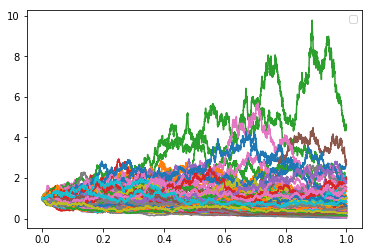

In [14]:
for i in range(100):
    plt.plot(t, Paths[i])
plt.legend()

No handles with labels found to put in legend.


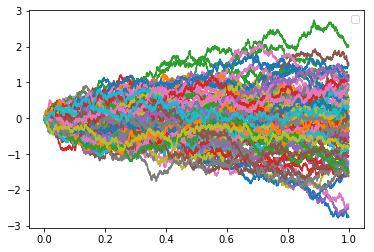

In [15]:
for i in range(100):
    plt.plot(t, W[i])
plt.legend()